<a href="https://colab.research.google.com/github/amankc/Fall24---Modeling/blob/main/assignment08/mod08Model_Calibration%E2%80%93Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import numbers

# The name of file that contains forcing and observed SWE during every day of water year 2001-2020
forcing_fname = 'EastRiver_hydro_data_2001-2020.csv'

# The name of the file containing parameter combinations and associated KGE values from our
# sensitivity analysis
saved_error_metric_values_fname = 'Snow17_sensitivity_analysis.csv'

date_beg = '2000-10-01' # This is the first day of water year 2016
date_end = '2020-09-30' # This is the last day of water year 2020

DD_i = np.array([2.0, 2.0, 9.0, 9.0]) # Initial guesses for degree-day factor
Tt_i = np.array([0.0, 6.0, 6.0, 0.0]) # Initial guesses for temperature threshold

In [2]:
# Read in the forcing data data
df_forcing = pd.read_csv(forcing_fname)

# Reindex to create make sure that the index for the dataframe is a datetime64 object
df_forcing['Date'] = pd.to_datetime(df_forcing['Date'],format='%Y-%m-%d')
df_forcing.index = df_forcing['Date']

ForcingDates = df_forcing[date_beg:date_end]['Date'].values
P_exp = df_forcing[date_beg:date_end]['pcp'].values
Ta_exp = df_forcing[date_beg:date_end]['tair'].values
SWE_o = df_forcing[date_beg:date_end]['SWE'].values

t = pd.date_range(start=date_beg, end=date_end, freq='1D')

# Here's what a pandas "dataframe" looks like:
df_forcing

,Date,tair,pcp,Q,SWE,PET
Date,,,,,,
2000-10-01,2000-10-01,10.555556,0.00,0.356384,NaN,4.960398
2000-10-02,2000-10-02,10.555556,0.00,0.334212,NaN,4.924742
2000-10-03,2000-10-03,8.333333,0.00,0.332784,NaN,4.243824
2000-10-04,2000-10-04,2.777778,7.62,0.327819,NaN,2.923413
2000-10-05,2000-10-05,4.444444,0.00,0.370463,NaN,3.244371
...,...,...,...,...,...,...
2020-09-26,2020-09-26,12.777778,0.00,0.228555,0.0,5.908478
2020-09-27,2020-09-27,9.444444,0.00,0.230085,0.0,4.757537
2020-09-28,2020-09-28,4.444444,0.00,0.230415,0.0,3.412351


In [3]:
def Snow17(Ta,P,DD,Tt):

    assert Ta.shape == P.shape, 'Precipitation and Temperature vectors must have the same shape'
    assert isinstance(DD, numbers.Number), 'Degree day coefficient must be a scalar'
    assert isinstance(Tt, numbers.Number), 'Temperature threshold must be a scalar'

    Nt = np.max(Ta.shape)

    SWE_s17 = np.zeros(Ta.shape)
    Sm_s17 = np.zeros(Ta.shape)
    Pliq_s17 = np.zeros(Ta.shape)

    for i in np.arange(Nt):

        P_i  = P[i] # The value of precipitation on this date
        Ta_i = Ta[i] # The value of average air temperature on this date

        # Initial conditions: we are starting when there should not be any appreciable snow in the watershed,
        # so we will assume that SWE = 0. If you decide to run another date when there might be snow (e.g., Jan. 1)
        # then you would need a more realistic value of SWE.
        if(i==0):
            SWE_i = 0.0
        else:
            SWE_i = SWE_s17[i-1] # The initial SWE on these dates is simply the SWE from the day before. We will add snow or subtract melt.

        # If SWE is greater than zero, there *may* be snowmelt
        if(SWE_i>0.0):
            if(Ta_i>Tt): # If the air temperature is greater than the threshold, there **will** be melt
                Sm_i = DD*(Ta_i-Tt) # Snowmelt via degree-day factor
            else: # If the air temperature is below the threshold, there is no melt
                Sm_i = 0.0 # No snowmelt if temperature does not exceed threshold
        else: # If there is no SWE, by definition there is no snowmelt
            Sm_i = 0.0

        # If there is precipitation, figure out its phase
        if((P_i>0.0) and (Ta_i<=Tt)):
            SWE_i += P_i # All precip will be added to SWE storage
            Pliq_i = 0.0 # There is no liquid precipitation
        elif((P_i>0.0) and (Ta_i>Tt)):
            Pliq_i = P_i # All precipitation falls as liquid. NOTE: We are assuming rain does not melt snow!!!
        else: # If there is no precipitation, there is nothing to accumulate
            Pliq_i = 0.0

        SWE_s17[i] = np.max([SWE_i - Sm_i,0.0]) # Make sure we can only melt as much SWE as there is. This only matters at low SWE
        Sm_s17[i] = Sm_i # Save the snowmelt... QUESTION: Is this something we can observe?!?!?!?!
        Pliq_s17[i] = Pliq_i


    return SWE_s17, Sm_s17, Pliq_s17

In [4]:
def RMSE(y_m,y_o):

    # Inputs:
    # y_m: Modeled time series
    # y_o: Observed time series

    RMSE = np.sqrt(np.nanmean((y_m - y_o)**2))

    return RMSE

In [5]:
def objective_function_rmse(params):
    DD_exp, Tt_exp = params # Get DD and Tt parameters

    # 1. Call Snow-17 model
    SWE_m, Sm_m, Pliq_m = Snow17(Ta_exp,P_exp,DD_exp,Tt_exp)

    # 2. Get RMSE value for simulated SWE
    RMSE_exp = RMSE(SWE_m,SWE_o)

    # 3. Return RMSE because the optimization function we're using seeks minimization
    return RMSE_exp


# RMSE_vals.shape
# np.zeros(N_ig)

In [6]:
N_ig = DD_i.size # The number of initial conditions being considered
# TODO: Create containers to store optimized DD and Tt
optimized_DD = np.zeros(N_ig)
optimized_Tt = np.zeros(N_ig)


for i in np.arange(N_ig):
    initial_guess = [DD_i[i], Tt_i[i]]# TODO: Get the initial conditions for this combination

    # Calibrate the model based on this initial guess
    optimized_params_rmse = optimize.minimize(
        objective_function_rmse,
        initial_guess,
        method='CG',
        jac='3-point',
        options={
            'disp': True,
            'maxiter': 2000,
        }
        )

    # Print the values of the optimized parameters to the screen
    print("Optimized Parameters:", optimized_params_rmse.x)

    # TODO: Store the calibrated parameters in the array you created above
    optimized_DD[i] = optimized_params_rmse.x[0]
    optimized_Tt [i] = optimized_params_rmse.x[1]

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 60.201041
         Iterations: 0
         Function evaluations: 342
         Gradient evaluations: 66
Optimized Parameters: [2. 0.]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 32.602012
         Iterations: 9
         Function evaluations: 437
         Gradient evaluations: 85
Optimized Parameters: [7.66340649 4.28108359]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: 32.602336
         Iterations: 10
         Function evaluations: 610
         Gradient evaluations: 118
Optimized Parameters: [7.6447222  4.27966492]
         Current function value: 32.602189
         Iterations: 13
         Function evaluations: 476
         Gradient evaluations: 93
Optimized Parameters: [7.69057233 4.28314745]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


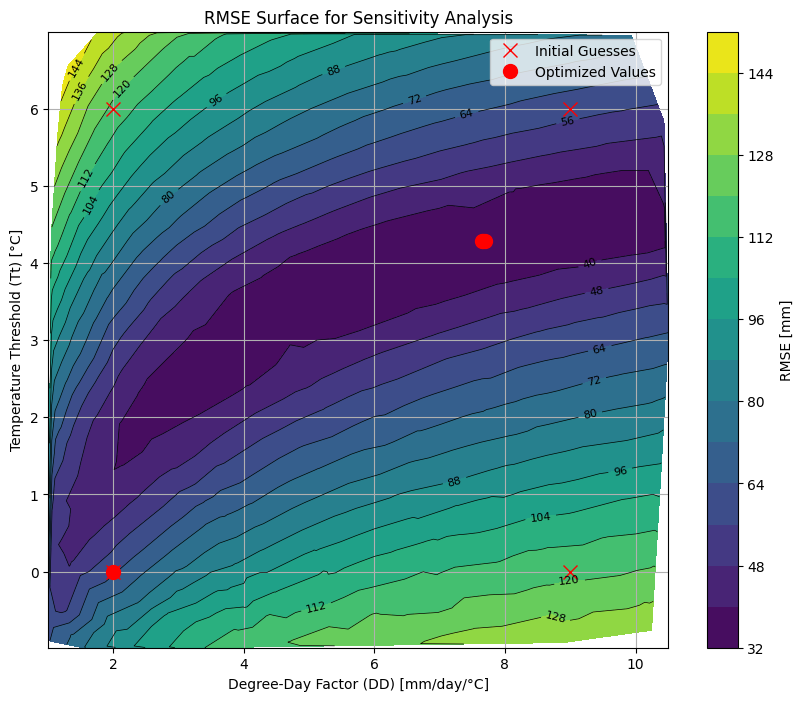

In [7]:
# Step 1: Read the RMSE surface from the file
sensitivity_data = pd.read_csv('Snow17_sensitivity_analysis.csv')
DD_vals = sensitivity_data['DD_sa'].values
Tt_vals = sensitivity_data['Tt_sa'].values
RMSE_vals = sensitivity_data['RMSE_sa'].values

# Step 3: Plot the RMSE surface using tricontour and tricontourf
plt.figure(figsize=(10, 8))

# Plot filled contours for RMSE surface
tricontourf_plot = plt.tricontourf(DD_vals, Tt_vals, RMSE_vals, levels=15, cmap='viridis')
plt.colorbar(tricontourf_plot, label='RMSE [mm]')

# Overlay contour lines
tricontour_plot = plt.tricontour(DD_vals, Tt_vals, RMSE_vals, levels=15, colors='k', linewidths=0.5)
plt.clabel(tricontour_plot, inline=True, fontsize=8)

# Plot initial guesses
plt.plot(DD_i, Tt_i, 'x', color='red', markersize=10, label='Initial Guesses')

# Plot optimized guesses
plt.plot(optimized_DD, optimized_Tt, 'o', color='red', markersize=10, label='Optimized Values')

# Add labels and title
plt.xlabel('Degree-Day Factor (DD) [mm/day/°C]')
plt.ylabel('Temperature Threshold (Tt) [°C]')
plt.title('RMSE Surface for Sensitivity Analysis')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [8]:
def MAE(y_m,y_o):
    MAE = np.mean(np.abs(y_m - y_o))
    return MAE

In [9]:
def objective_function_mae(params):

    DD_exp, Tt_exp = params

    SWE_m, Sm_m, Pliq_m = Snow17(Ta_exp, P_exp, DD_exp, Tt_exp)

    MAE_exp = MAE(SWE_m, SWE_o)  # Calculate the Mean Absolute Error

    # Return the MAE for optimization (minimization)
    return MAE_exp


In [13]:
N_ig = DD_i.size # The number of initial conditions being considered
# TODO: Create containers to store optimized DD and Tt
optimized_DD2 = np.zeros(N_ig)
optimized_Tt2 = np.zeros(N_ig)


for i in np.arange(N_ig):
    initial_guess = [DD_i[i], Tt_i[i]]# TODO: Get the initial conditions for this combination

    # Calibrate the model based on this initial guess
    optimized_params_mae = optimize.minimize(
        objective_function_mae,
        initial_guess,
        method='CG',
        jac='3-point',
        options={
            'disp': True,
            'maxiter': 2000,
        }
        )

    # Print the values of the optimized parameters to the screen
    print("Optimized Parameters:", optimized_params_mae.x)

    # TODO: Store the calibrated parameters in the array you created above
    optimized_DD2[i] = optimized_params_mae.x[0]
    optimized_Tt2[i] = optimized_params_mae.x[1]



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:706: OptimizeWarning: NaN result encountered.
  res = _minimize_cg(fun, x0, args, jac, callback, **options)


         Current function value: nan
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimized Parameters: [2. 0.]
         Current function value: nan
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimized Parameters: [2. 6.]
         Current function value: nan
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimized Parameters: [9. 6.]
         Current function value: nan
         Iterations: 0
         Function evaluations: 5
         Gradient evaluations: 1
Optimized Parameters: [9. 0.]


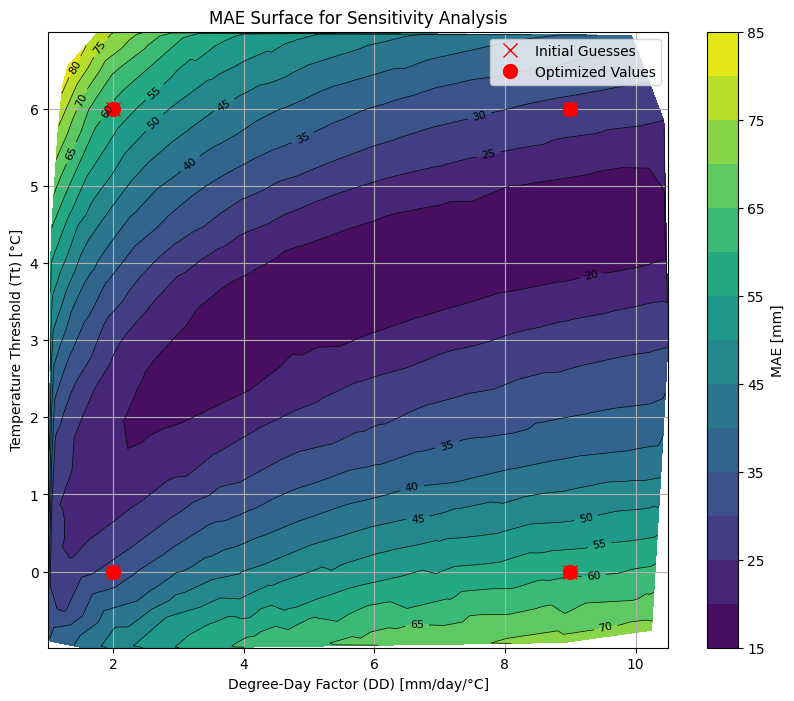

In [14]:
# Step 1: Read the RMSE surface from the file
mae_vals = sensitivity_data['MAE_sa'].values

# Step 3: Plot the RMSE surface using tricontour and tricontourf
plt.figure(figsize=(10, 8))

# Plot filled contours for RMSE surface
tricontourf_plot = plt.tricontourf(DD_vals, Tt_vals, mae_vals, levels=15, cmap='viridis')
plt.colorbar(tricontourf_plot, label='MAE [mm]')

# Overlay contour lines
tricontour_plot = plt.tricontour(DD_vals, Tt_vals, mae_vals, levels=15, colors='k', linewidths=0.5)
plt.clabel(tricontour_plot, inline=True, fontsize=8)

# Plot initial guesses
plt.plot(DD_i, Tt_i, 'x', color='red', markersize=10, label='Initial Guesses')

# Plot optimized guesses
plt.plot(optimized_DD2, optimized_Tt2, 'o', color='red', markersize=10, label='Optimized Values')

# Add labels and title
plt.xlabel('Degree-Day Factor (DD) [mm/day/°C]')
plt.ylabel('Temperature Threshold (Tt) [°C]')
plt.title('MAE Surface for Sensitivity Analysis')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


##1. How sensitive are the optimized parameters to the initial guess? Did calibrating to MAE result in appreciably different results when compared to calibrating to RMSE?

Response:  In the MAE sensitivity plot, the final optimized points shifted significantly away from the initial guesses, indicating that the optimization algorithm adjusted parameters in response to the MAE surface. MAE tends to reduce systematic error uniformly, while RMSE places more emphasis on large deviations

##2. What are the implications of the above results? How would you coach a colleague who is considering creating a Snow-17 model for a different location in, for example, Washington or Idaho?

Response: Initial guesses are reasonable, but the optimization process can adjust to converge on reasonable solutions. I would start with reasonable ranges for DD and TT, informed by literature or local knowledge, maybe DD ≈ 1.5 to 3.0 mm/°C/day and TT Range: 0.0 to 1.0 °C.

##3. How generalizable do you think your conclusions are for other models? Based on what we've done in this module? How might you approach calibration of a model that is of a completely different process but of similar complexity? For example, say you needed to calibrate the advection-dispersion code to a time series of contaminant concentration in an observation well some known distance away from an oil spill with a known date?

Response: Looking at error surfaces (like MAE or RMSE) helped me understand which parameters matter most and how errors behave. So it might mean calibration methods can improve poor guesses, but starting with reasonable values  saves time.

As we found, MAE and RMSE gave slightly different results. For other models (e.g., contaminant transport), other metrics might work better. We can test how sensitive the results are , use optimization methods to minimize error, and validate results with new data to ensure the model works well.